Mestrado em Modelagem Matematica da Informacao
----------------------------------------------
Disciplina: Modelagem e Mineracao de Dados
------------------------------------------

Master Program - Mathematical Modeling of Information
-----------------------------------------------------
Course: Data Mining and Modeling
--------------------------------

Professor: Renato Rocha Souza
-----------------------------

### Topic: Clustering news feeds 

Information on the Python Packages used:  
http://www.feedparser.org/  
http://docs.python.org/library/re.html  
http://pillow.readthedocs.io/en/3.0.x/index.html (PIL for Python 3)  
http://nltk.org/ 
https://github.com/grangier/python-goose  

In [1]:
import feedparser
import re
import random
import nltk
import IPython
import os
import codecs
import string
from bs4 import BeautifulSoup 
from PIL import Image,ImageDraw, ImageFont
from math import sqrt

Specifying the path to the files

In [2]:
datapath = "../datasets/"
outputs = "../outputs/"

Choosing the list of feeds to capture

In [3]:
listafeeds = ['feedlist_en.txt', 'feedlist_br.txt'] 
lfeeds = os.path.join(datapath,listafeeds[1])

Output files

In [4]:
saida = "captured_feeds.txt"
dendrog1 = "feedclusters.jpg"
dendrog2 = "wordclusters.jpg"
g2d1 = "g2dfeeds.jpg"
g2d2 = "g2dwords.jpg"
fw_cluster='feeds_words_cluster.txt'

fsaida = os.path.join(outputs,saida)
dendsaida = os.path.join(outputs,dendrog1)
dendsaida2 = os.path.join(outputs,dendrog2)
g2dsaida = os.path.join(outputs,g2d1)
g2dsaida2 = os.path.join(outputs,g2d2)
fwc_saida = os.path.join(outputs,fw_cluster)

Parameters for the PIL Graphs

In [5]:
fontfile = "/usr/share/fonts/truetype/ttf-dejavu/DejaVuSans.ttf"
graphfont = ImageFont.truetype(fontfile, 12, encoding='utf-8')

Choosing the list of stopwords

In [6]:
stoplist_en = nltk.corpus.stopwords.words('english')
stoplist_pt = nltk.corpus.stopwords.words('portuguese')
ignorewords = stoplist_en + stoplist_pt

#### Reading and processing the words in blog feeds

Two ways of cleaning the feeds: using re and using BeautifulSoup

In [7]:
def getwords(html):
    '''Remove the HTML tags and cleans the feeds files;
    splits the sentences by the non alpha characters
    and converts all words to lowercase'''
    #txt = re.compile(r'<[^>]+>').sub('',html)
    #words = re.compile('\\W*', flags=re.U).split(txt)
    words = BeautifulSoup(html, "lxml").findAll(text=True)[0].split()
    words = [w.strip(string.punctuation) for w in words]
    return [word.lower() for word in words if word!='']

Accessing and cleaning one feeds and cleaning with getwords. Returns a dict of word counts for the feed 

In [8]:
def getwordcounts(url):
    '''Parse the feed and returns a dictionary with word counts
    for each feed entry, it searches for summary ou description
    (optionally) eliminating the stopwords. Cleans feeds with function getwords'''
    d = feedparser.parse(url)
    wc = {}
    for entry in d.entries:
        if 'summary' in entry:
            summary = entry.summary
        else:
            summary = entry.description
        words = getwords(entry.title+' '+summary)
        words = [word for word in words if word not in ignorewords] #eliminating stopwords
        words = [word for word in words if not word.isdigit()] #eliminating numbers
        for word in words:
            wc.setdefault(word,0) #setting default values to zero
            wc[word] += 1 # incrementing every time it occurs
    return d.feed.title,wc

Accessing all the feeds with getwordcounts. Generates two new dictionaries: the feeds in which a word occur, and the times a word appear in a feed

In [9]:
def getwordcountfeeds(lfeeds, feedlist):
    '''tries to access the feed using the function getwordcounts and returns
    two dictionaries: the feeds in which a word occur, and the times a word appear in a feed'''    
    apcount = {}
    wordcounts = {}
    for feedurl in feedlist:
        print(u'Accessing feed: {}'.format(feedurl))
        try:
            title,wc = getwordcounts(feedurl)
            wordcounts[title] = wc
            for word,count in wc.items():
                apcount.setdefault(word,0)
                if count > 1:
                    apcount[word] += 1
            print(u'Succeeded accessing feed {}'.format(feedurl))
        except:
            print(u'Failure trying to access feed {}'.format(feedurl))
    return apcount, wordcounts

This is a kind of filter for very common or very rare words. May or may not be used

In [10]:
def neither_common_nor_rare(apcount, feedlist):
    '''Optional function, to filter unwanted words (very common or very rare)'''
    wordlist = []
    for w,bc in apcount.items():
        frac = float(bc)/len(feedlist)
        if frac > 0.1 and frac < 0.9: #parameters needs to be adjusted
            wordlist.append(w)
    return wordlist

#### Saving data files to persist data gathered and retrieving the data saved for future analysis

Save name of feeds, words and its frequencies. Names the heads of the files and separate columns by "tabs"

In [11]:
def createoutputfile(wordlist, wordcounts, filename):
    '''Save name of feeds, words and its frequencies.
    Names the heads of the files and separate columns by <tabs>'''
    out = codecs.open(filename, "w", "utf-8")
    out.write(u'Feed')
    for word in wordlist: 
        out.write(u'\t{}'.format(word))
    out.write(u'\n')
    for feed,wc in wordcounts.items():
        print(u'Processing the feed: {}'.format(feed))
        out.write(feed)
        for word in wordlist:
            if word in wc:
                out.write(u'\t{}'.format(wc[word]))
            else: out.write(u'\t0')
        out.write(u'\n')

Read the file and formats data

In [12]:
def readfile(filename):
    '''Read the file and formats data'''
    lines = [line for line in codecs.open(filename, "r", "utf-8")]
    colnames = lines[0].strip().split(u'\t')[1:]
    colnames = [w for w in colnames]
    rownames = []
    data = []
    for line in lines[1:]:
        p = line.strip().split(u'\t')
        rownames.append(p[0])
        data.append([float(x) for x in p[1:]])
    return rownames,colnames,data

Transposes the rows and collumns from any list of lists of the same size

In [13]:
def transposematrix(data):
    newdata = []
    for i in range(len(data[0])):
        newrow = [data[j][i] for j in range(len(data))]
        newdata.append(newrow)
    return newdata

#### Calculating the clusters

Creating a class to represent our cluster  
TO DO: implement all the code using http://pythonhosted.org/ete2/index.html

In [14]:
class bicluster:
    '''representing a hierarchical partioned cluster'''
    def __init__(self,vec,left = None, right = None,distance = 0.0,id = None):
        self.left = left
        self.right = right
        self.vec = vec
        self.id = id
        self.distance = distance

Using an algorith to calculate correlation:  
http://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient

In [15]:
def pearson(v1,v2):
    '''One of the many algorithms to calculate correlation
    as an alternative to euclidean distance'''
    # Simple sums
    sum1 = sum(v1)
    sum2 = sum(v2)
    # Sums of the squares
    sum1Sq = sum([pow(v,2) for v in v1])
    sum2Sq = sum([pow(v,2) for v in v2])
    # Sum of the products
    pSum = sum([v1[i]*v2[i] for i in range(len(v1))])
    # Calculate r (Pearson score)
    num = pSum-(sum1*sum2/len(v1))
    den = sqrt((sum1Sq-pow(sum1,2)/len(v1))*(sum2Sq-pow(sum2,2)/len(v1)))
    if den == 0: return 0
    return 1.0-num/den

Calculating hierarchical clusters. Can be used for words using feeds as features, or for feeds, using words as features

In [16]:
def hcluster(rows,distance=pearson):
    '''Calculating hierarchical clusters'''
    distances = {}
    currentclustid =- 1
    # Initially, each word is a cluster
    clust=[bicluster(rows[i],id=i) for i in range(len(rows))]
    while len(clust) > 1:
        lowestpair = (0,1)
        closest = distance(clust[0].vec,clust[1].vec)
        # loop through every pair looking for the smallest distance
        for i in range(len(clust)):
            for j in range(i+1,len(clust)):
                # distances is the cache of distance calculations
                if (clust[i].id,clust[j].id) not in distances: 
                    distances[(clust[i].id,clust[j].id)]=distance(clust[i].vec,clust[j].vec)
                d = distances[(clust[i].id,clust[j].id)]
                if d < closest:
                    closest = d
                    lowestpair = (i,j)
        # calculate the average of the two clusters
        mergevec = [(clust[lowestpair[0]].vec[i]+clust[lowestpair[1]].vec[i])/2.0 
                  for i in range(len(clust[0].vec))]
        # create the new cluster
        newcluster = bicluster(mergevec,left = clust[lowestpair[0]],
                             right = clust[lowestpair[1]], 
                             distance = closest,id = currentclustid)
        # cluster ids that weren't in the original set are negative
        currentclustid -= 1
        del clust[lowestpair[1]]
        del clust[lowestpair[0]]
        clust.append(newcluster)
    return clust[0]

Another way to calculate clusters, creating "k" sets/clusters by proximity

In [17]:
def kcluster(rows,distance=pearson,k=10):
    '''Calculating clusters using K-means'''
    # Determine the minimum and maximum values for each point
    ranges=[(min([row[i] for row in rows]),max([row[i] for row in rows])) 
    for i in range(len(rows[0]))]
    # Create k randomly placed centroids
    clusters=[[random.random()*(ranges[i][1]-ranges[i][0])+ranges[i][0] 
    for i in range(len(rows[0]))] for j in range(k)]
    lastmatches=None
    for t in range(100):
        print('Iteration {}'.format(t))
        bestmatches=[[] for i in range(k)]
        # Find which centroid is the closest for each row
        for j in range(len(rows)):
            row=rows[j]
            bestmatch=0
            for i in range(k):
                d=distance(clusters[i],row)
                if d<distance(clusters[bestmatch],row): bestmatch=i
            bestmatches[bestmatch].append(j)
        # If the results are the same as last time, this is complete
        if bestmatches==lastmatches: break
        lastmatches=bestmatches
        # Move the centroids to the average of their members
        for i in range(k):
            avgs=[0.0]*len(rows[0])
            if len(bestmatches[i])>0:
                for rowid in bestmatches[i]:
                    for m in range(len(rows[rowid])):
                        avgs[m]+=rows[rowid][m]
                for j in range(len(avgs)):
                    avgs[j]/=len(bestmatches[i])
                clusters[i]=avgs
    return bestmatches

Scaling the distances for plotting the clusters in 2D

In [18]:
def scaledown(data,distance=pearson,rate=0.01):
    '''Calculating the actual distances among the items'''
    n=len(data)
    # The real distances between every pair of items
    realdist=[[distance(data[i],data[j]) for j in range(n)] 
                                         for i in range(0,n)]
    # Randomly initialize the starting points of the locations in 2D
    loc=[[random.random(),random.random()] for i in range(n)]
    fakedist=[[0.0 for j in range(n)] for i in range(n)]
    lasterror=None
    for m in range(0,1000):
        # Find projected distances
        for i in range(n):
            for j in range(n):
                fakedist[i][j]=sqrt(sum([pow(loc[i][x]-loc[j][x],2) 
                                    for x in range(len(loc[i]))]))
        # Move points
        grad=[[0.0,0.0] for i in range(n)]
        totalerror=0
        for k in range(n):
            for j in range(n):
                if j==k: continue
                # The error is percent difference between the distances
                if realdist[j][k] != 0:
                    errorterm=(fakedist[j][k]-realdist[j][k])/realdist[j][k]
                # Each point needs to be moved away from or towards the other
                # point in proportion to how much error it has
                grad[k][0]+=((loc[k][0]-loc[j][0])/fakedist[j][k])*errorterm
                grad[k][1]+=((loc[k][1]-loc[j][1])/fakedist[j][k])*errorterm
                # Keep track of the total error
                totalerror+=abs(errorterm)
        #print(totalerror)
        # If the answer got worse by moving the points, we are done
        if lasterror and lasterror<totalerror: break
        lasterror=totalerror
        # Move each of the points by the learning rate times the gradient
        for k in range(n):
            loc[k][0]-=rate*grad[k][0]
            loc[k][1]-=rate*grad[k][1]
    return loc

#### Designing and drawing the clusters

In [19]:
def getheight(clust):
    # Is this an endpoint? Then the height is just 1
    if clust.left==None and clust.right==None: return 1
    # Otherwise the height is the same of the heights of each branch
    return getheight(clust.left)+getheight(clust.right)

In [20]:
def getdepth(clust):
    # The distance of an endpoint is 0.0
    if clust.left==None and clust.right==None: return 0
    # The distance of a branch is the greater of its two sides plus its own distance
    return max(getdepth(clust.left),getdepth(clust.right))+clust.distance

In [21]:
def drawnode(draw,clust,x,y,scaling,labels):
    if clust.id < 0:
        h1=getheight(clust.left)*20
        h2=getheight(clust.right)*20
        top=y-(h1+h2)/2
        bottom=y+(h1+h2)/2
        # Line length
        ll=clust.distance*scaling
        # Vertical line from this cluster to children    
        draw.line((x,top+h1/2,x,bottom-h2/2),fill=(255,0,0))    
        # Horizontal line to left item
        draw.line((x,top+h1/2,x+ll,top+h1/2),fill=(255,0,0))    
        # Horizontal line to right item
        draw.line((x,bottom-h2/2,x+ll,bottom-h2/2),fill=(255,0,0))        
        # Call the function to draw the left and right nodes    
        drawnode(draw,clust.left,x+ll,top+h1/2,scaling,labels)
        drawnode(draw,clust.right,x+ll,bottom-h2/2,scaling,labels)
    else:   
        # If this is an endpoint, draw the item label
        draw.text((x+5,y-7),labels[clust.id],(0,0,0), font=graphfont)

In [22]:
def drawdendrogram(clust,labels,jpeg='clusters.jpg'):
    # height and width
    h=getheight(clust)*20
    w=1200
    depth=getdepth(clust)
    # width is fixed, so scale distances accordingly
    scaling=float(w-150)/depth
    # Create a new image with a white background
    img=Image.new('RGB',(w,h),(255,255,255))
    draw=ImageDraw.Draw(img)
    draw.line((0,h/2,10,h/2),fill=(255,0,0))    
    # Draw the first node
    drawnode(draw,clust,10,(h/2),scaling,labels)
    img.save(jpeg,'JPEG')

In [23]:
def draw2d(data,labels,jpeg='mds2d.jpg'):
    img=Image.new('RGB',(2000,2000),(255,255,255))
    draw=ImageDraw.Draw(img)
    for i in range(len(data)):
        x=(data[i][0]+0.5)*1000
        y=(data[i][1]+0.5)*1000
        '''print(labels[i])'''
        draw.text((x,y),labels[i],(0,0,0), font=graphfont)
    img.save(jpeg,'JPEG')

### Processing the feeds

* Reading the list of blogs to analyze

In [24]:
feedlist=[line.strip() for line in open(lfeeds)]

* Accessing blogs - rss feeds

In [25]:
apcount, wordcounts = getwordcountfeeds(lfeeds, feedlist)

Accessing feed: http://www.band.uol.com.br/rss/noticias.xml
Succeeded accessing feed http://www.band.uol.com.br/rss/noticias.xml
Accessing feed: http://www.band.com.br/rss/brasil.xml
Failure trying to access feed http://www.band.com.br/rss/brasil.xml
Accessing feed: http://www.band.com.br/rss/cidades.xml
Failure trying to access feed http://www.band.com.br/rss/cidades.xml
Accessing feed: http://www.band.com.br/rss/mundo.xml
Failure trying to access feed http://www.band.com.br/rss/mundo.xml
Accessing feed: http://www.band.com.br/rss/esquisito.xml
Failure trying to access feed http://www.band.com.br/rss/esquisito.xml
Accessing feed: http://www.band.com.br/rss/ciencia.xml
Failure trying to access feed http://www.band.com.br/rss/ciencia.xml
Accessing feed: http://www.band.com.br/rss/economia.xml
Succeeded accessing feed http://www.band.com.br/rss/economia.xml
Accessing feed: http://www.band.com.br/rss/tecnologia.xml
Succeeded accessing feed http://www.band.com.br/rss/tecnologia.xml
Accessi

* Processing the feeds

In [26]:
wordlist = neither_common_nor_rare(apcount, feedlist)

* Creating an output file with results

In [27]:
createoutputfile(wordlist, wordcounts, fsaida)

Processing the feed: G1 > Mundo
Processing the feed: G1 > Loterias
Processing the feed: G1 > Economia
Processing the feed: Política > Julgamento do mensalão
Processing the feed: Folha de S.Paulo - Folhinha - Principal
Processing the feed: Valor Econômico - Brasil
Processing the feed: Folha de S.Paulo - Ilustríssima - Principal
Processing the feed: Band Esporte
Processing the feed: Folha de S.Paulo - Em cima da hora - Principal
Processing the feed: Folha de S.Paulo - Opinião - Principal
Processing the feed: Folha de S.Paulo - Mercado - Principal
Processing the feed: Folha de S.Paulo - Equilíbrio e Saúde - Principal
Processing the feed: Valor Econômico - Opinião
Processing the feed: Valor Econômico - Internacional
Processing the feed: Valor Econômico - Carreira
Processing the feed: Rádio Bandeirantes Notícias - Economia
Processing the feed: Folha de S.Paulo - Turismo - Principal
Processing the feed: Folha de S.Paulo - Ilustrada - Principal
Processing the feed: G1 > Ciência e Saúde
Proces

* Reading the results file

In [28]:
feednames,words,freqwords = readfile(fsaida)

* Drawing the (hierarchical) dendrogram by feeds

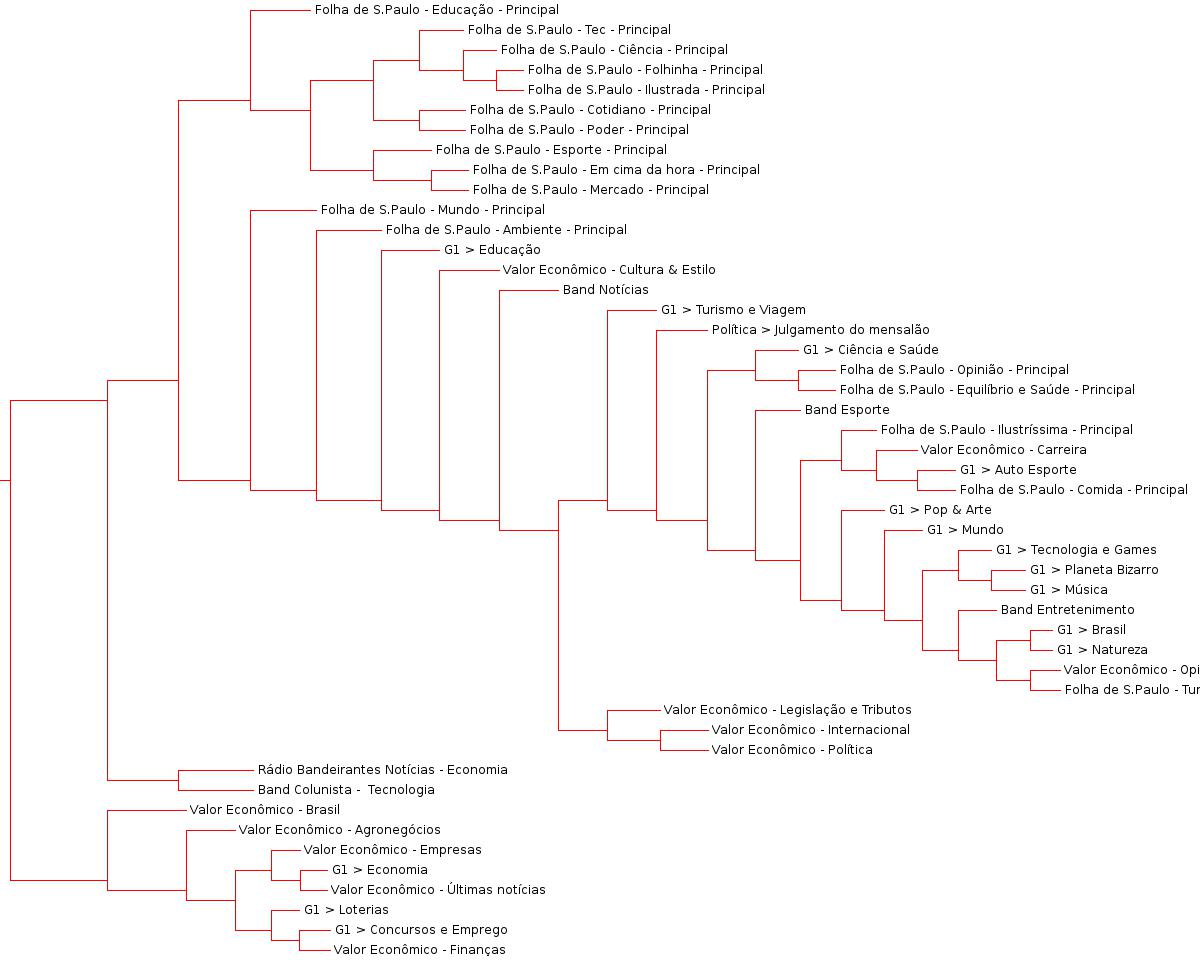

In [29]:
feedclust = hcluster(freqwords)
drawdendrogram(feedclust,feednames,jpeg=dendsaida)
IPython.core.display.Image(filename=dendsaida, format=u'jpg')

* Inverting the data matrix

In [30]:
freqfeeds = transposematrix(freqwords)

* Drawing the (hierarchical) dendrogram by words

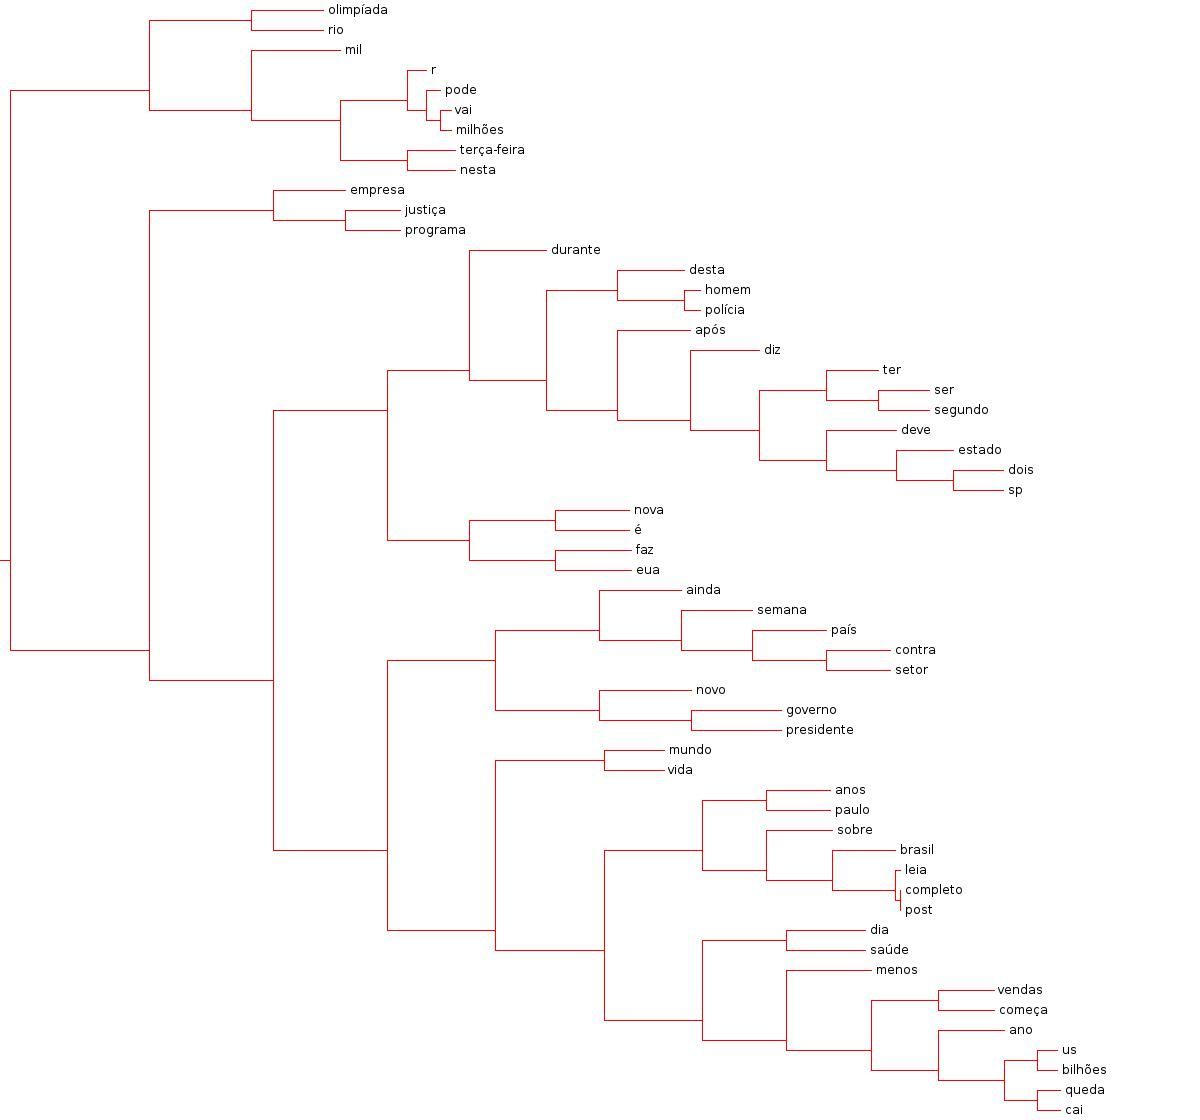

In [31]:
wordclust = hcluster(freqfeeds) 
drawdendrogram(wordclust,words,jpeg=dendsaida2)
IPython.core.display.Image(filename=dendsaida2)

* Drawing the 2D map by feeds

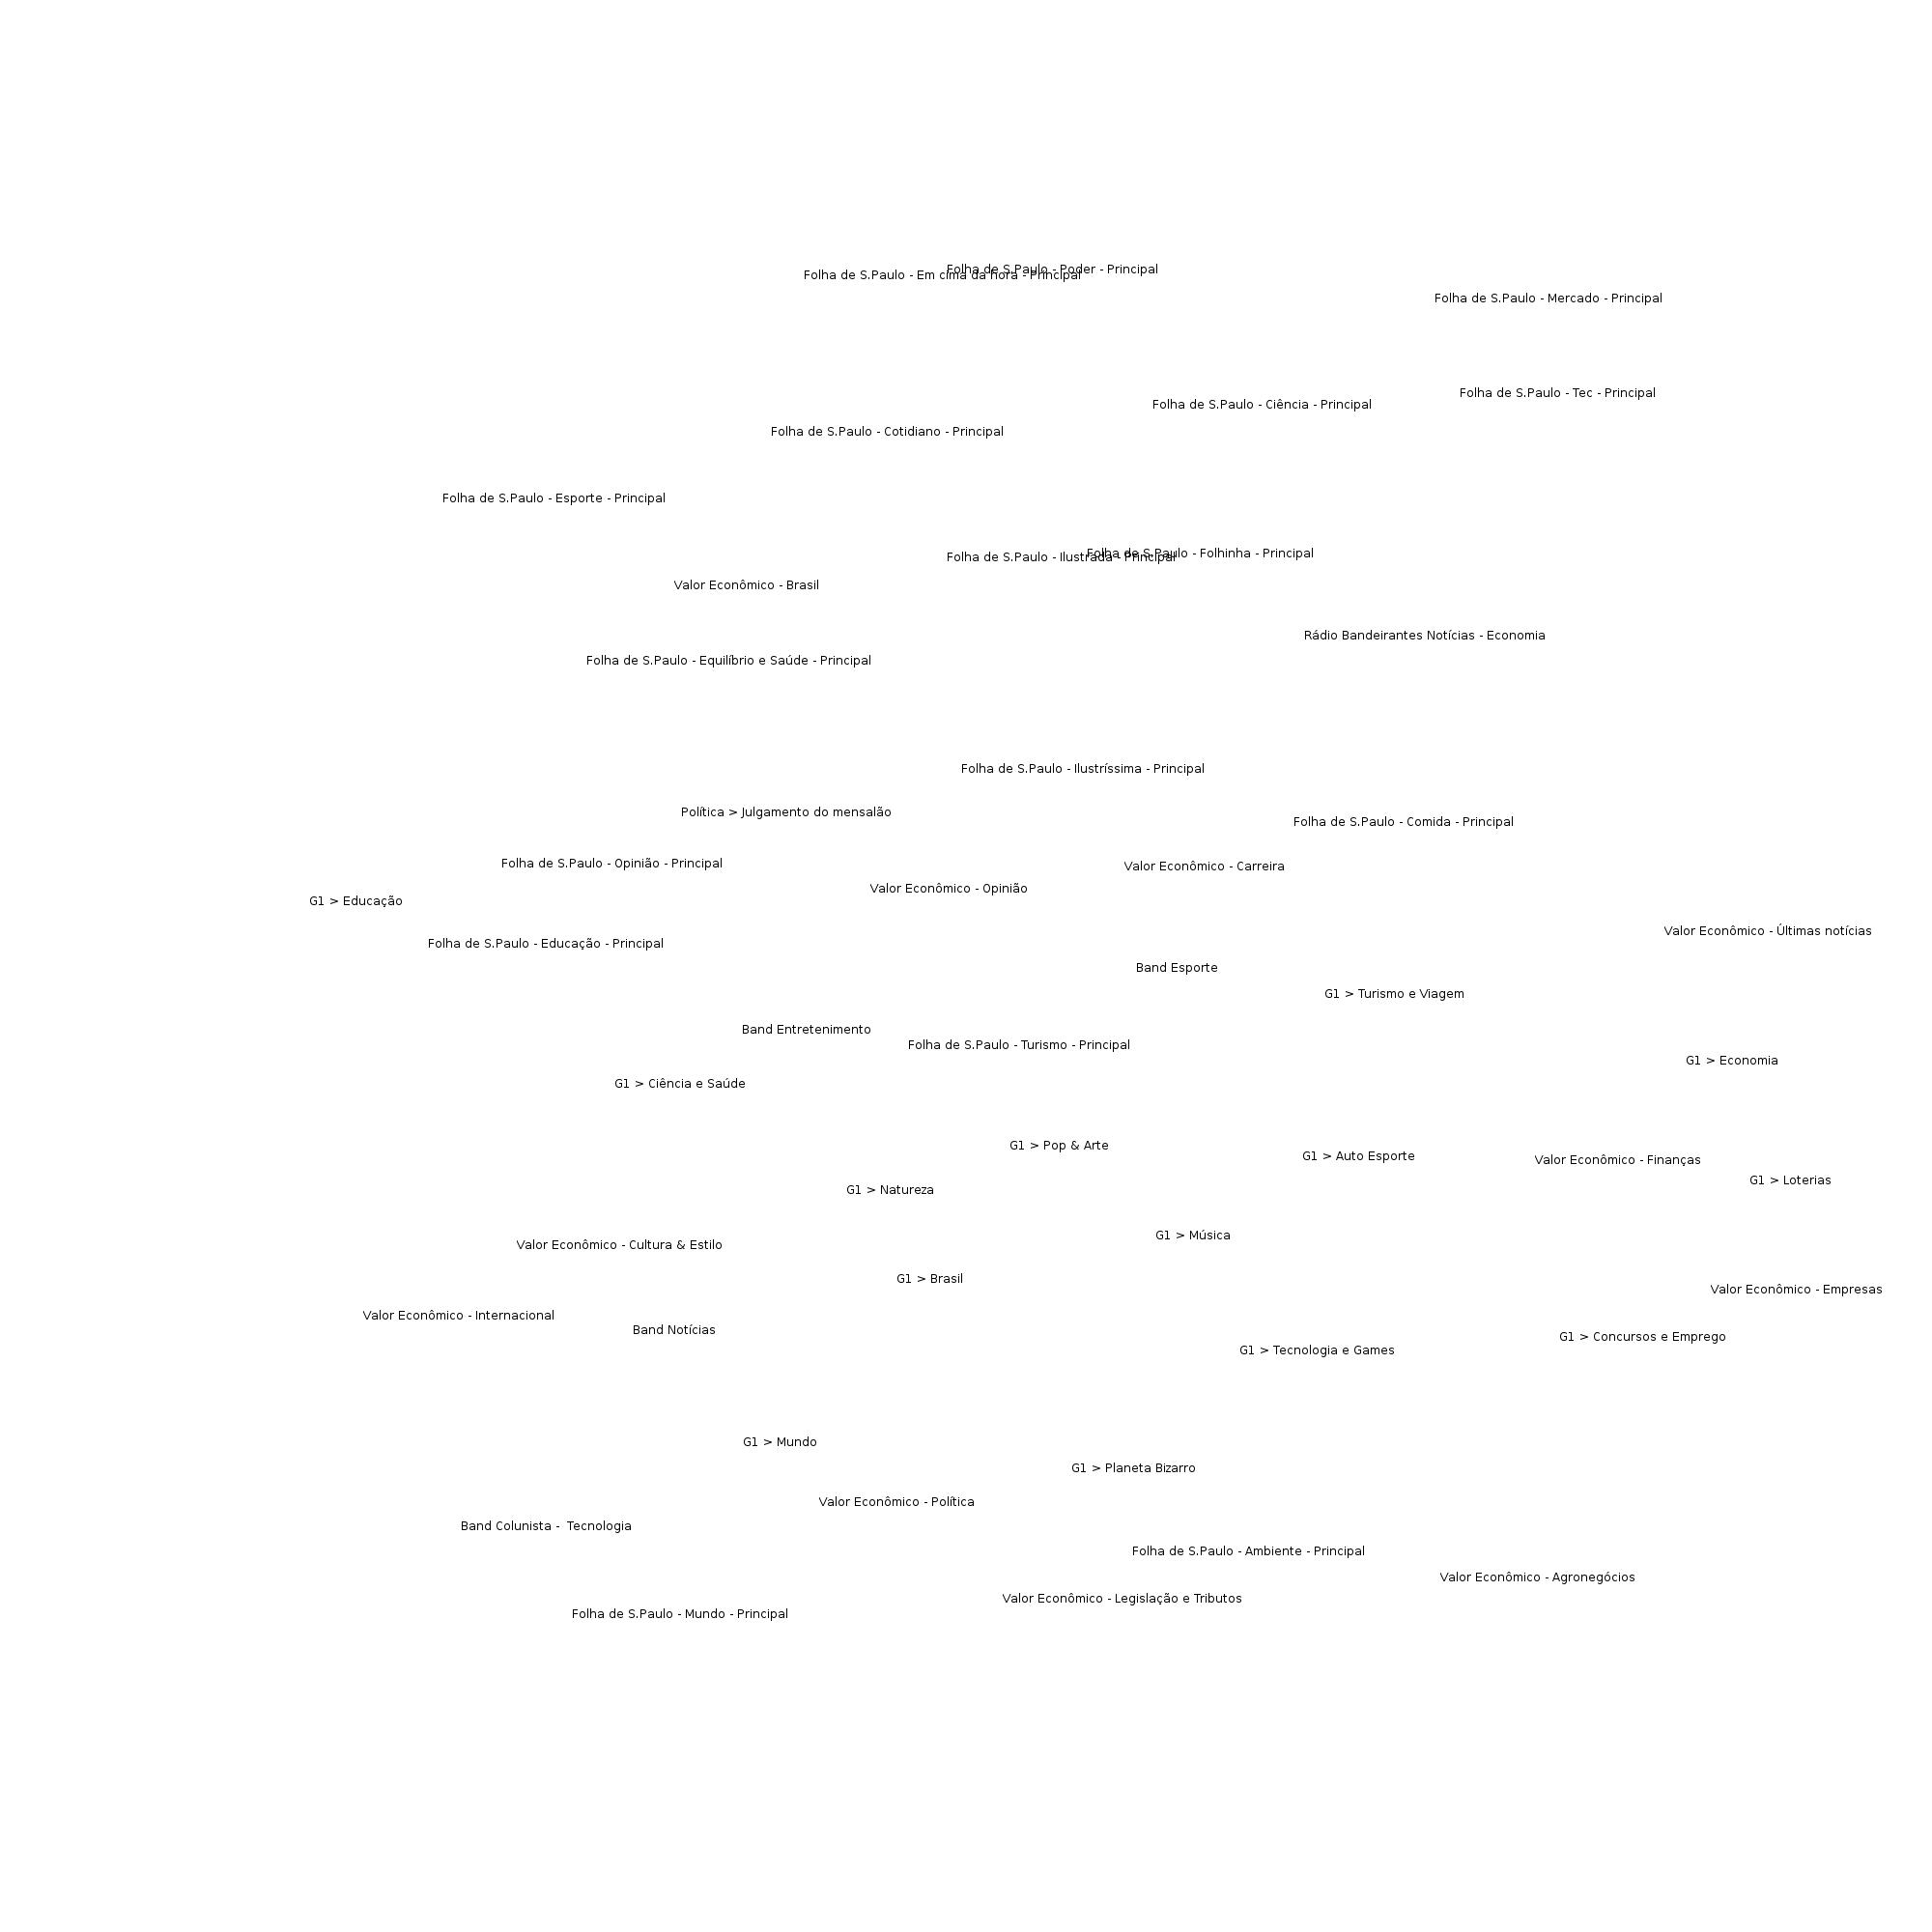

In [32]:
coordsf = scaledown(freqwords)
draw2d(coordsf, feednames, jpeg=g2dsaida)
IPython.core.display.Image(filename=g2dsaida)

* Drawing the 2D map by words

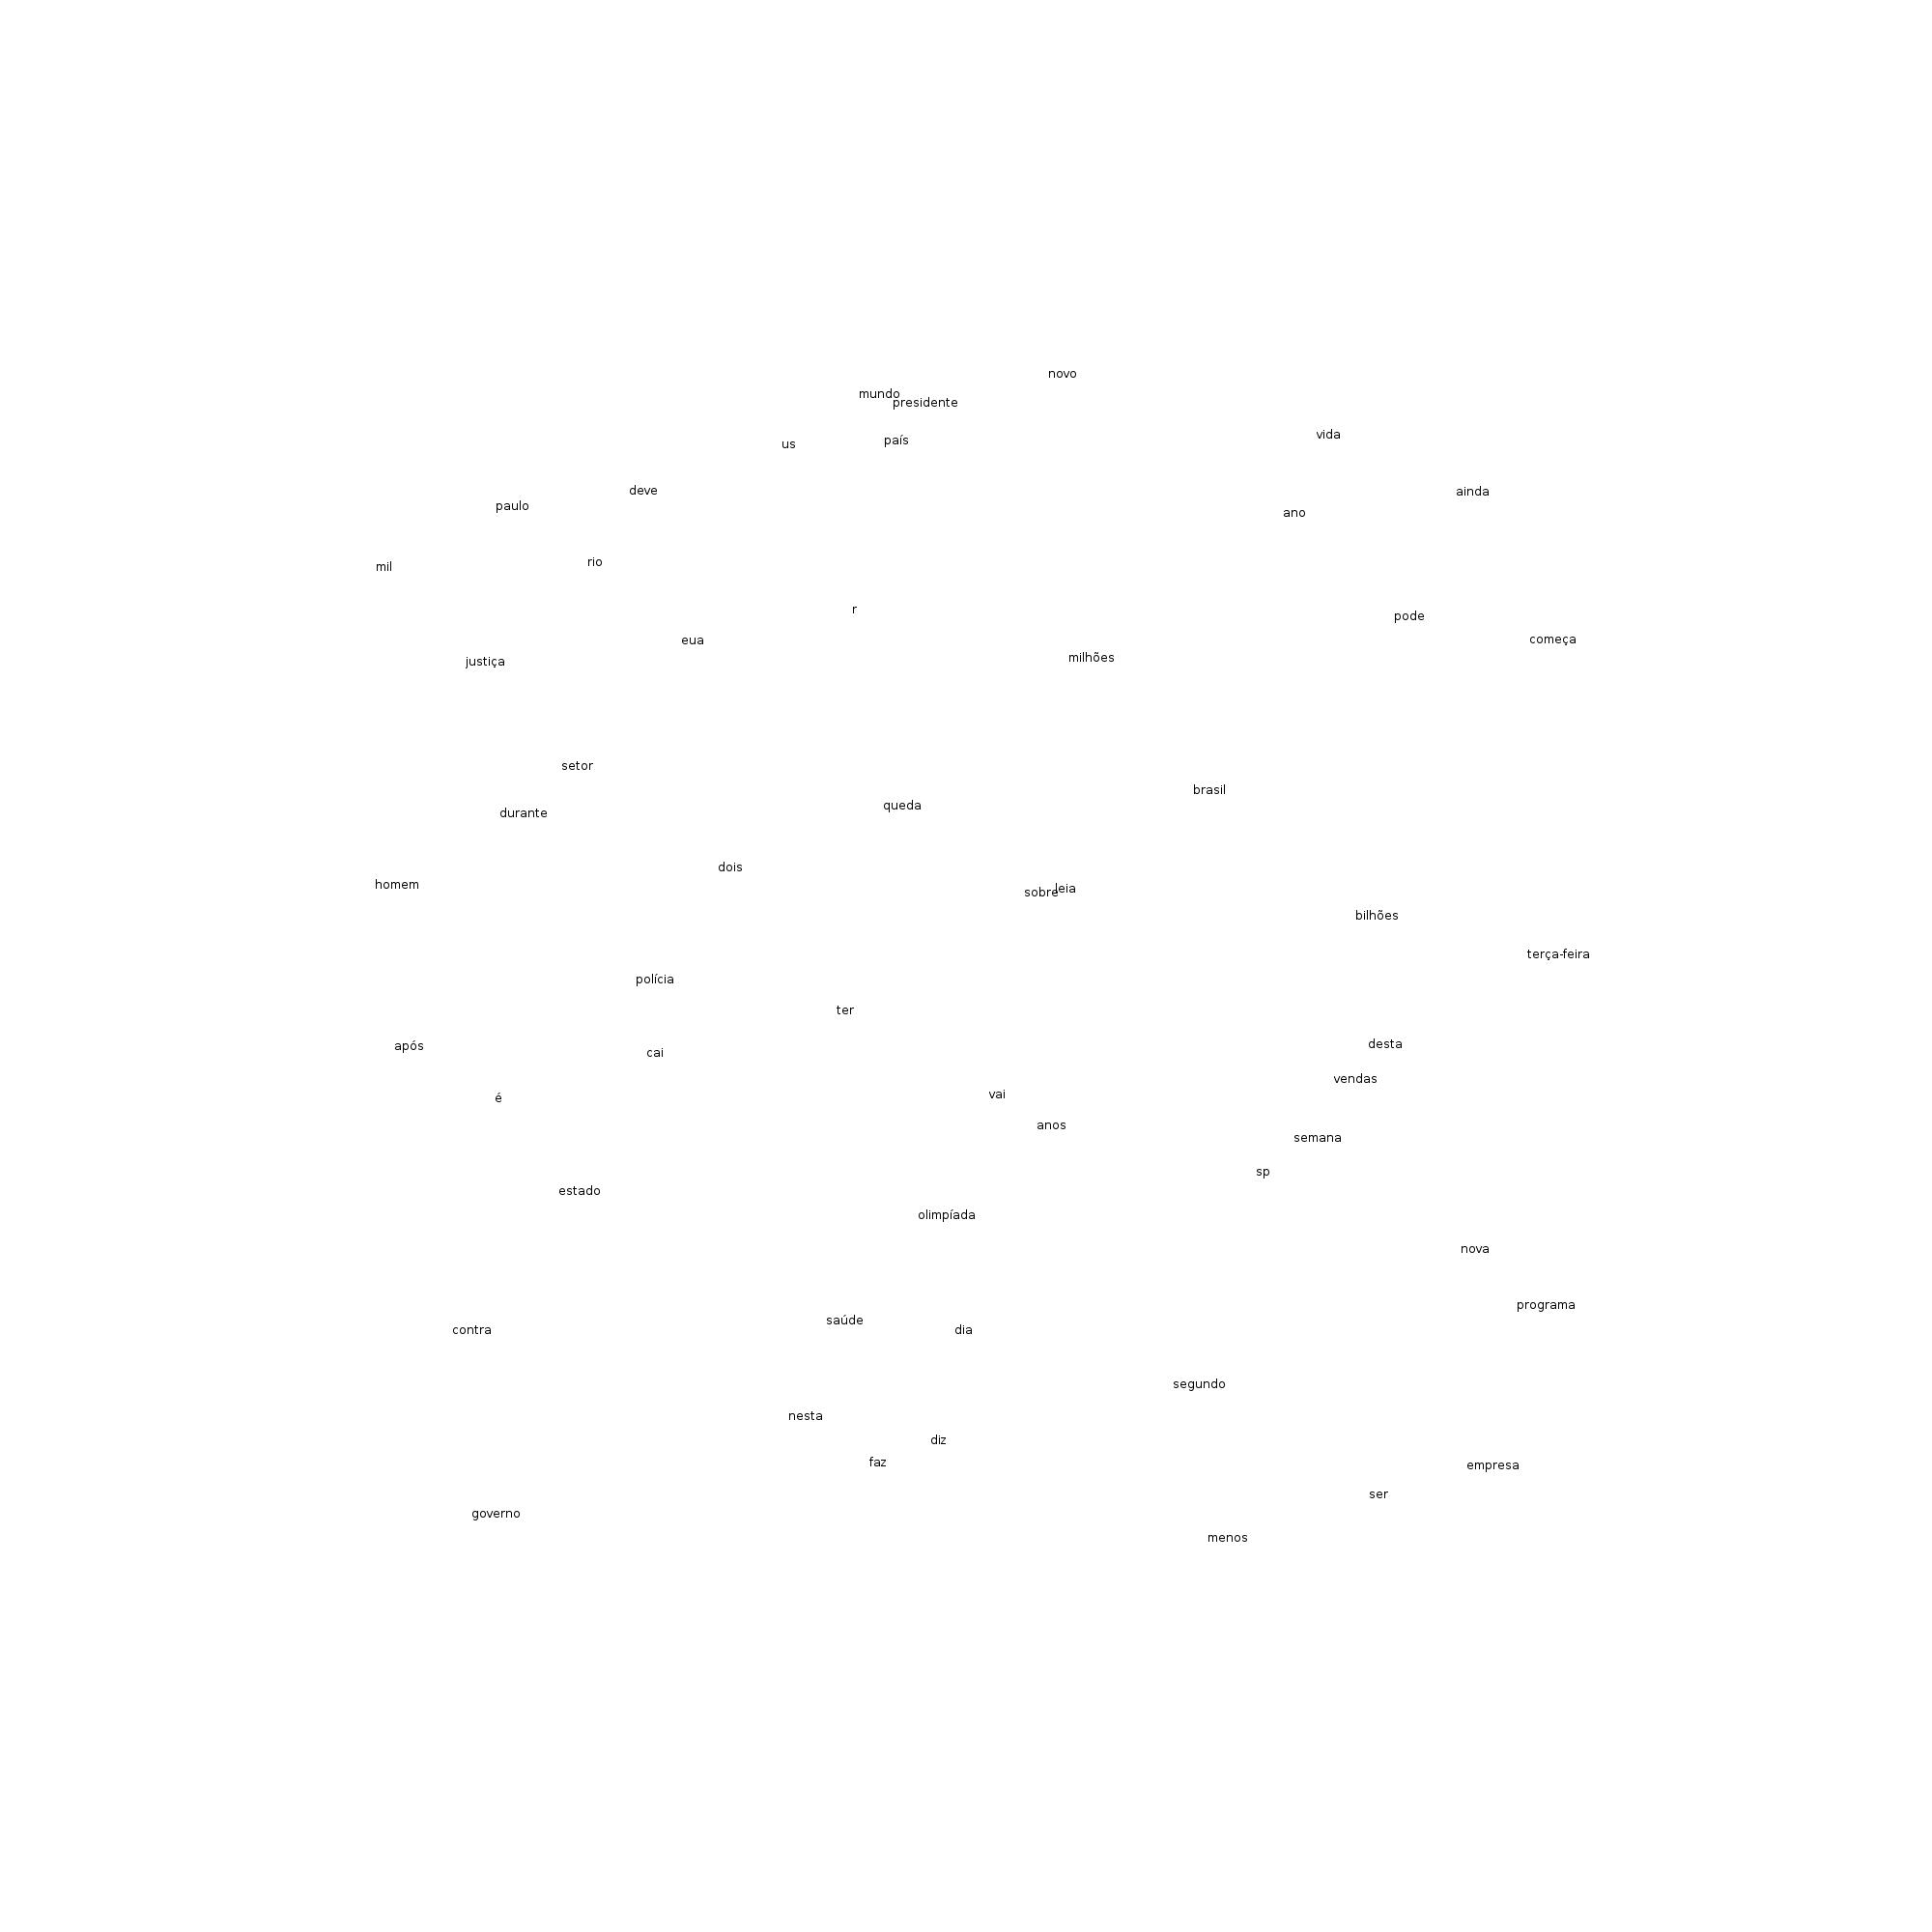

In [33]:
coordsw = scaledown(freqfeeds)
draw2d(coordsw, words, jpeg=g2dsaida2)
IPython.core.display.Image(filename=g2dsaida2)

* Cluster feeds and words usando k-means

In [34]:
f = codecs.open(fwc_saida, "w", "utf-8")
kfeedcluster = kcluster(freqwords,k=6)
kwordcluster = kcluster(freqfeeds,k=10)    
f.write(u'\n*** Feeds cluster ***\n\n')    
for i in range(len(kfeedcluster)):
    print(u'\nCluster #{}\n'.format(i))
    f.write(u'\n\nCluster #{}\n\n'.format(i))
    for item in [feednames[r] for r in kfeedcluster[i]]:
        print(u'{}'.format(item))
        f.write(u'{}\n'.format(item))
f.write(u'\n\n*** Words cluster ***\n\n')
for i in range(len(kwordcluster)):
    print(u'\nCluster #{}\n'.format(i))
    f.write(u'\n\nCluster #{}\n\n'.format(i))        
    for item in [words[r] for r in kwordcluster[i]]:
        print(u'{}'.format(item))
        f.write(u'{}\n'.format(item))
f.close()

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4

Cluster #0

G1 > Loterias
Band Esporte
Valor Econômico - Agronegócios

Cluster #1

G1 > Mundo
Folha de S.Paulo - Ilustríssima - Principal
Folha de S.Paulo - Opinião - Principal
Folha de S.Paulo - Equilíbrio e Saúde - Principal
Valor Econômico - Opinião
Valor Econômico - Internacional
Valor Econômico - Carreira
Folha de S.Paulo - Turismo - Principal
G1 > Ciência e Saúde
Folha de S.Paulo - Mundo - Principal
G1 > Brasil
G1 > Planeta Bizarro
G1 > Música
Band Notícias
G1 > Tecnologia e Games
Valor Econômico - Política
G1 > Pop & Arte
Band Entretenimento
G1 > Turismo e Viagem
Folha de S.Paulo - Ambiente - Principal
G1 > Natureza
G1 > Educação

Cluster #2

Folha de S.Paulo - Folhinha - Principal
Folha de S.Paulo - Em cima da hora - Principal
Folha de S.Paulo - Mercado - Principal
Rádio Bandeirantes Notícias - Economia
Folha de S.Paulo - Ilustrada - P